In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import save_model, load_model
import seaborn as sns
sns.set_theme()

path_data = 'data/'
path_train='Sentinel2LULC_354/'
path_test='Test 2/'
path_models='gdrive/MineriaIII/models/'
path_pred='gdrive/MineriaIII/predictions/'
ext_sub = '.csv'

In [8]:
data = []
labels = []

for d in os.listdir(path_data + path_train):
    lab = int(re.search('\d{1,2}', d).group())
    for f in os.listdir(path_data + path_train + d):
        try:
            img = imread(path_data + path_train + d + '/' + f)
            data.append(img)
            labels.append(lab)
        except:
            print("Cannot read file: " + d + '/' + f)

data = np.array(data)
labels = np.array(labels)

In [9]:
test_data = []
test_labels = []

for f in os.listdir(path_data + path_test):
    lab = int(re.search('^(\d{1,2})_', f).group(1))
    try:
        img = imread(path_data + path_test + f)
        test_data.append(img)
        test_labels.append(lab)
    except:
        print("Cannot read file: " + f)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [ ]:
#data = data.astype('float32')/255.0
#test_data = test_data.astype('float32')/255.0

data_prep = tf.keras.applications.vgg19.preprocess_input(data)
del data
test_data_prep = tf.keras.applications.vgg19.preprocess_input(test_data)
del test_data

In [10]:
nclasses = len(np.unique(labels))
img_shape = data_prep.shape[1:4]
factor_labels = np.min(labels)

#data_augmentation = tf.keras.Sequential([
#      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#      tf.keras.layers.experimental.preprocessing.RandomContrast(0.5)
#  ])

In [11]:
batch_size = 64
shuffle_buffer_size = 1000

train, val = train_test_split(np.arange(len(labels)), test_size=0.1, random_state=31, stratify=labels)
train_data = data_prep[train]
train_labels = labels[train]
val_data = data_prep[val]
val_labels = labels[val]
del data_prep

train_labels_coded = tf.one_hot(train_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
val_labels_coded = tf.one_hot(val_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)
test_labels_coded = tf.one_hot(test_labels-factor_labels, depth=nclasses, on_value=1, off_value=0)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_data), tf.convert_to_tensor(train_labels_coded)))
#train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
del train_data
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_data), tf.convert_to_tensor(val_labels_coded)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_data_prep), tf.convert_to_tensor(test_labels_coded)))

train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)

In [12]:
def create_model(binary=False):
  base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=img_shape, pooling='avg')
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(nclasses)
  ])
  return model


def train_evaluate_model(model, name, binary=False, lr=0.0001):
  metric = 'categorical_accuracy'
  metric_val = 'val_categorical_accuracy'

  earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor=metric_val,
    verbose=1,
    mode='max',
    patience=10,
    restore_best_weights=True
  )
  epochs = 100
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  metrics = [tf.keras.metrics.categorical_accuracy]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history = model.fit(train_batches,
                      epochs=epochs, 
                      validation_data=val_batches,
                      callbacks=[earlystopping])
  
  save_model(model, path_models + name + '.h5')

  test_loss, test_acc = model.evaluate(test_batches)
  print('Test loss: ' + str(test_loss) + ', test acc: ' + str(test_acc))
  
  val_preds = np.argmax(model.predict(val_data), axis=-1)
  test_preds = np.argmax(model.predict(test_data_prep), axis=-1)
  val_matrix = tf.math.confusion_matrix(val_labels-factor_labels, val_preds)
  test_matrix = tf.math.confusion_matrix(test_labels-factor_labels, test_preds)

  fig, ax = plt.subplots(1, 2, figsize=(20,8))
  axlabs = [str(l) for l in np.unique(np.sort(train_labels))]

  im = sns.heatmap(ax=ax[0], data=val_matrix, annot=True, fmt="d")
  ax[0].set_xticks(np.arange(nclasses))
  ax[0].set_yticks(np.arange(nclasses))
  ax[0].set_xticklabels(axlabs)
  ax[0].set_yticklabels(axlabs)
  ax[0].set_title("Validation conf matrix")

  im = sns.heatmap(ax=ax[1], data=test_matrix, annot=True, fmt="d")
  ax[1].set_xticks(np.arange(nclasses))
  ax[1].set_yticks(np.arange(nclasses))
  ax[1].set_xticklabels(axlabs)
  ax[1].set_yticklabels(axlabs)
  ax[1].set_title("Test confusion matrix")

  plt.show()
  
  
def prep_finetuning(model, from_layer):
  model.layers[0].trainable = True
  for layer in model.layers[0].layers[:from_layer]:
    layer.trainable =  False

Epoch 1/100
145/145 [==============================] - 172s 1s/step - loss: 2.3461 - categorical_accuracy: 0.2918 - val_loss: 1.3824 - val_categorical_accuracy: 0.5297
Epoch 2/100
145/145 [==============================] - 147s 1s/step - loss: 1.2715 - categorical_accuracy: 0.5650 - val_loss: 0.9235 - val_categorical_accuracy: 0.6534
Epoch 3/100
145/145 [==============================] - 150s 1s/step - loss: 0.9341 - categorical_accuracy: 0.6815 - val_loss: 0.9967 - val_categorical_accuracy: 0.6865
Epoch 4/100
145/145 [==============================] - 151s 1s/step - loss: 0.7893 - categorical_accuracy: 0.7248 - val_loss: 0.7356 - val_categorical_accuracy: 0.7274
Epoch 5/100
145/145 [==============================] - 152s 1s/step - loss: 0.6638 - categorical_accuracy: 0.7734 - val_loss: 0.6938 - val_categorical_accuracy: 0.7663
Epoch 6/100
145/145 [==============================] - 152s 1s/step - loss: 0.6225 - categorical_accuracy: 0.7881 - val_loss: 0.4975 - val_categorical_accuracy:

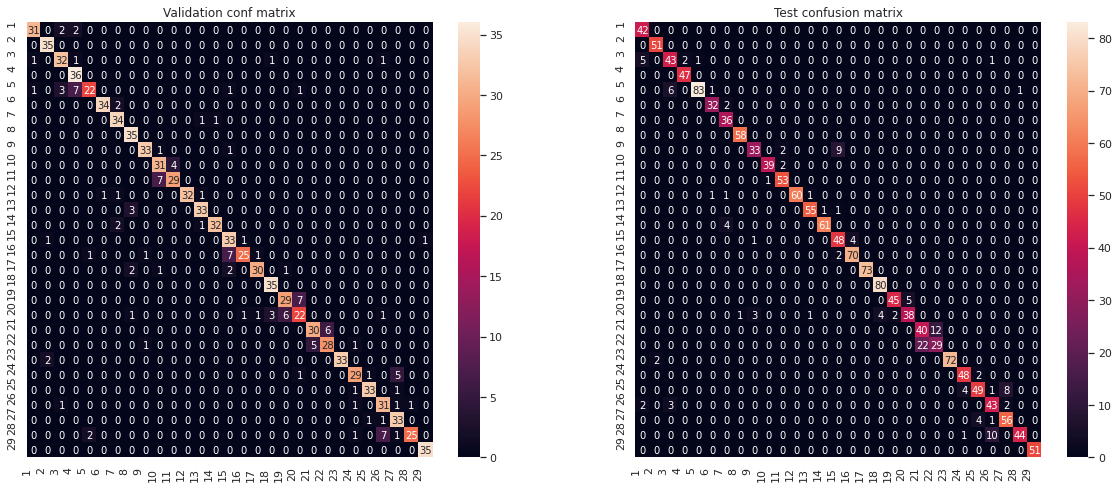

In [ ]:
model = create_model()
prep_finetuning(model, 0)
train_evaluate_model(model, 'all_1024-512-128_ft')

Epoch 1/100
145/145 [==============================] - 169s 1s/step - loss: 0.2113 - categorical_accuracy: 0.9269 - val_loss: 0.1995 - val_categorical_accuracy: 0.9299
Epoch 2/100
145/145 [==============================] - 152s 1s/step - loss: 0.1825 - categorical_accuracy: 0.9354 - val_loss: 0.2007 - val_categorical_accuracy: 0.9299
Epoch 3/100
145/145 [==============================] - 153s 1s/step - loss: 0.1653 - categorical_accuracy: 0.9413 - val_loss: 0.1960 - val_categorical_accuracy: 0.9260
Epoch 4/100
145/145 [==============================] - 153s 1s/step - loss: 0.1633 - categorical_accuracy: 0.9416 - val_loss: 0.2007 - val_categorical_accuracy: 0.9309
Epoch 5/100
145/145 [==============================] - 153s 1s/step - loss: 0.1475 - categorical_accuracy: 0.9487 - val_loss: 0.2122 - val_categorical_accuracy: 0.9299
Epoch 6/100
145/145 [==============================] - 153s 1s/step - loss: 0.1405 - categorical_accuracy: 0.9528 - val_loss: 0.2163 - val_categorical_accuracy:

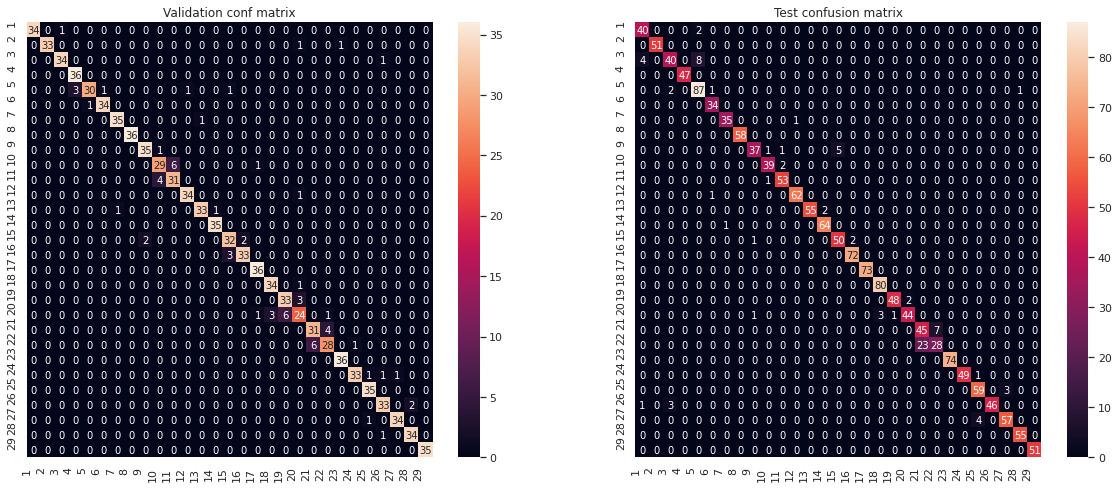

In [ ]:
model = load_model(path_models + 'all_1024-512-128_ft.h5')
train_evaluate_model(model, 'all_1024-512-128_ft_v2', lr=0.00001)